# Normalizing SparseDream

## Intro
* **Date**: 12/29/2020
* **What**: This is basically just standard SparseDream, but I need to figure out how to get the output to scale linearly with the input (given lateral inhibition, of course), which I think requires some weighted averages.  So I'm going to play around with a couple different architectures, and see what I can get to work.  By work, I mean the allowed outputs scale with inputs, all the neurons learn prototypes over time, and when I introduce lateral excitation, neurons don't dominate each other laterally.
* **Why**: Shoot, I kinda just answered this.  Basically I haven't been seeing the three things from the **What** behave properly simultaneously, and I really really want to.  Especially before I start messing with an invariant second layer.  
* **Hopes**: As previously mentioned, I want to see the three things I mentioned in the **What** section work simultaneously.  That'd be dope.
* **Limitations**: Adding any notion of weighted average ensures that the output scales with the input, so I won't be surprised if some neurons dominate the feed-forward input, and if some neurons dominate weaker neurons laterally.  I suppose we'll simply have to see.  Weighted averages makes literally everything go berserk.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

x_tr = x_tr / 255.0

t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 0

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

In [2]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 10_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])

In [3]:
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, sl ** 2)

In [4]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

## Analysis Dialog

Ok, first things first, we're going to try this:

$$
p = \frac{\sum{v^2 w}}{\sum{vw}}
$$

I think if I use this maneuver, the network won't be as swayed by all the incorrect pixels in the prototypes at the beginning that keep bad neurons from learning.  It's a double-mask weighted-average maneuver.  

<IPython.core.display.Javascript object>


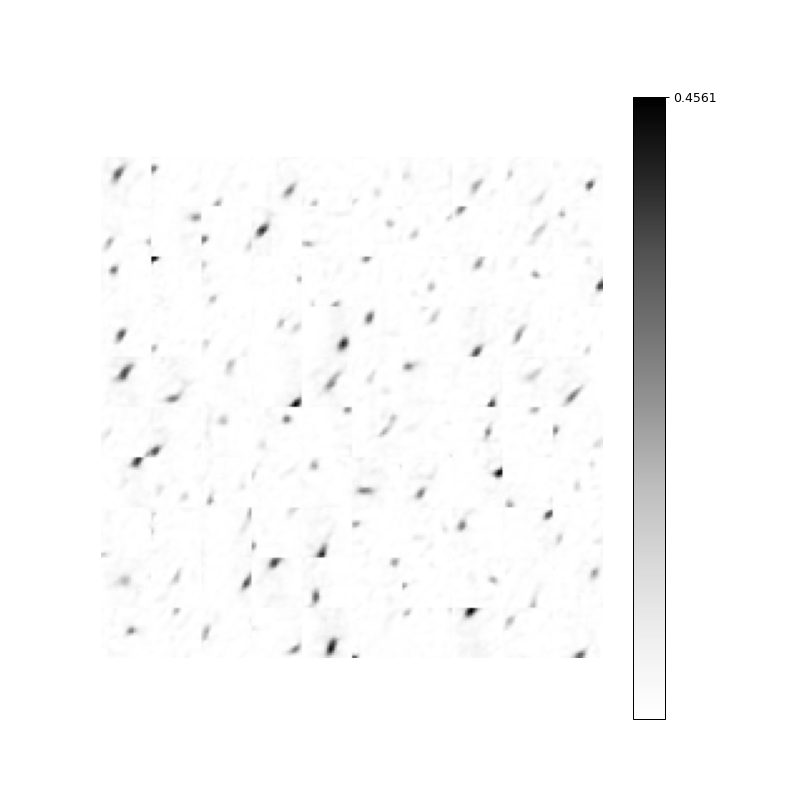

100%|█████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2332.88it/s]


In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 10 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.005

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ np.square(v) / np.maximum(w @ v, prec)
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w, Kx, Ky, sl, fig)

Wow, well it seems to be good at not leaving neurons behind.  That being said, it's pretty darn unstable.  Let's see how it does with the tapestry traversal.

<IPython.core.display.Javascript object>


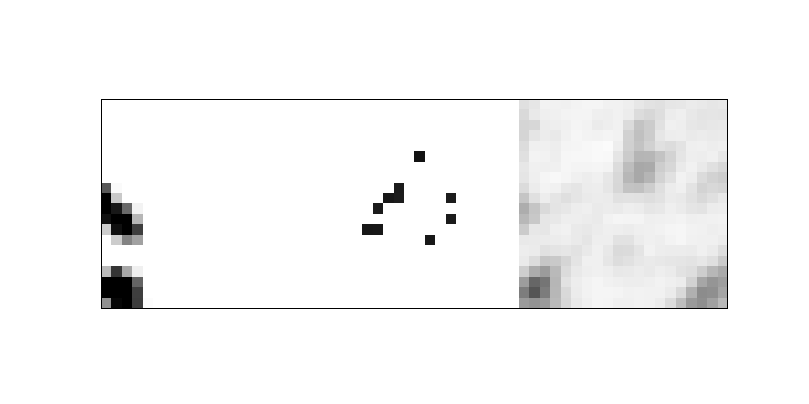

100%|█████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1050.08it/s]


In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w @ np.square(v) / np.maximum(w @ v, prec)
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
#     mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[5:15, 25:35] = o.reshape(10, 10)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Good heavens.  It appears the animation is pretty bad.  I'm going to try it again with a smaller $\xi$ and see if that helps at all.

<IPython.core.display.Javascript object>


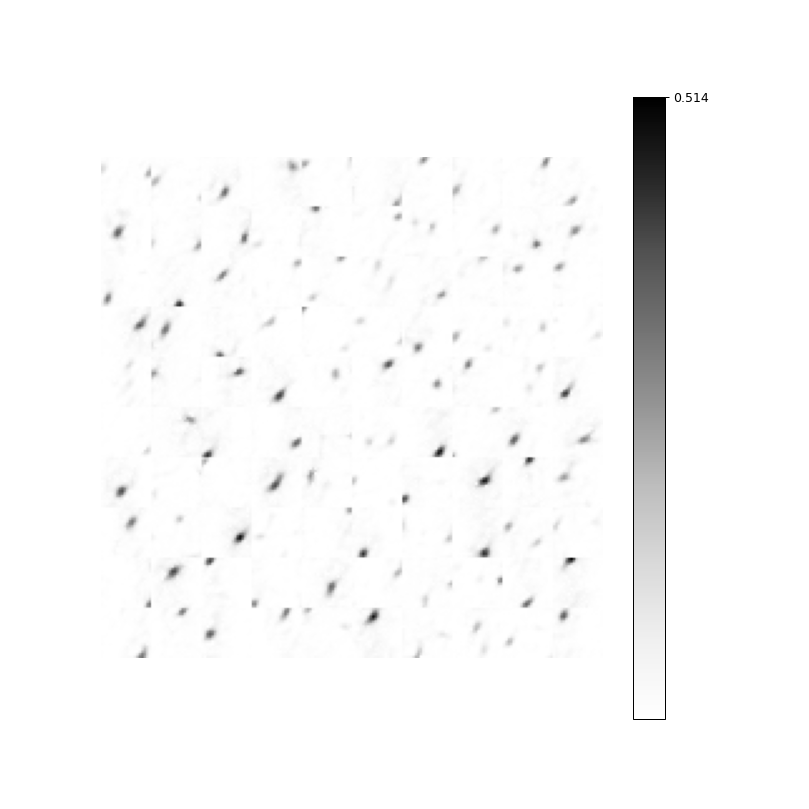

100%|█████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2337.13it/s]


In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 10 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.002

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ np.square(v) / np.maximum(w @ v, prec)
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


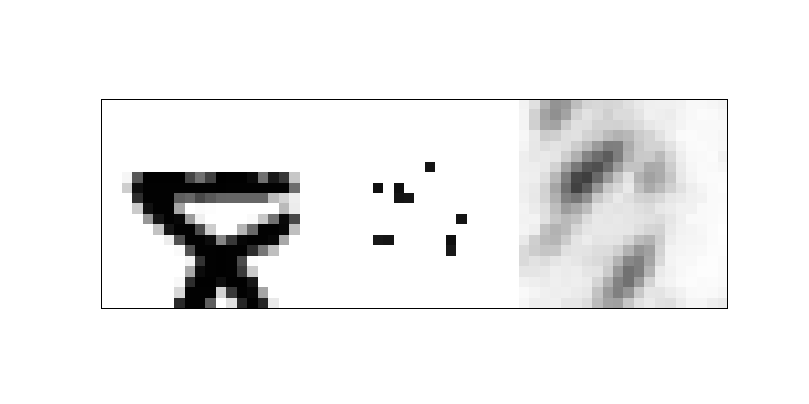

100%|█████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1046.37it/s]


In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w @ np.square(v) / np.maximum(w @ v, prec)
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
#     mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[5:15, 25:35] = o.reshape(10, 10)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Yeah, wow, those reconstructions are literal garbage.  I'm going to mess around with a smaller number of winner, see how that does.

<IPython.core.display.Javascript object>


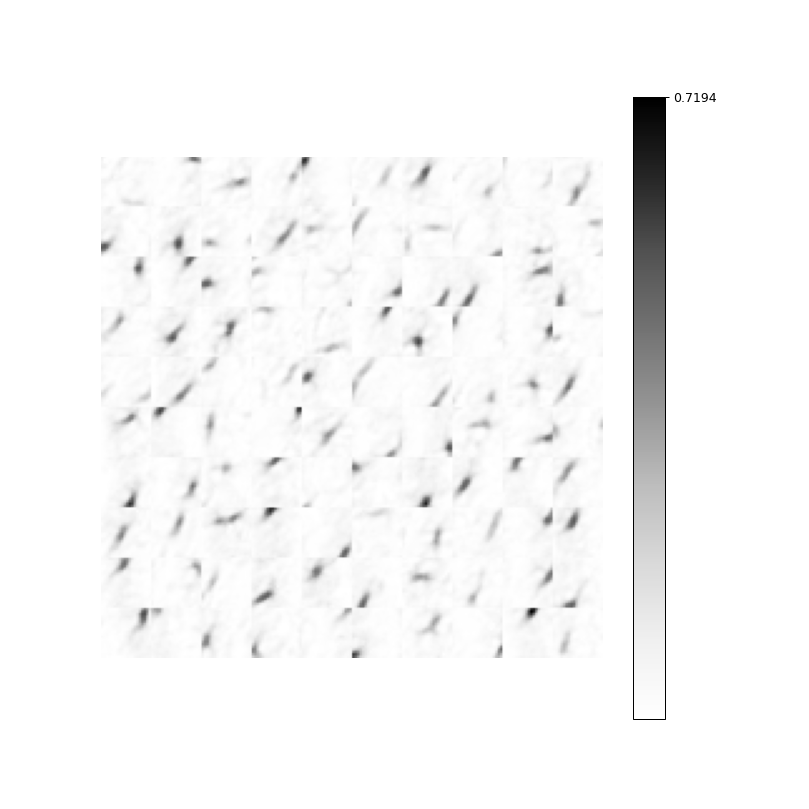

100%|█████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2307.00it/s]


In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 3 #Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.01

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ np.square(v) / np.maximum(w @ v, prec)
        winners = np.argsort(p, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


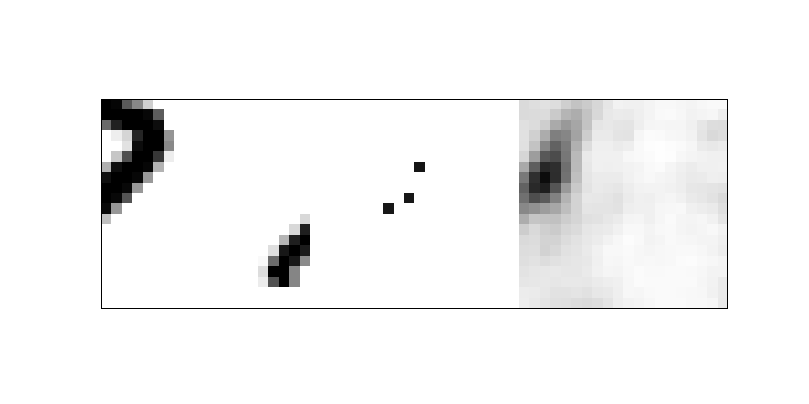

100%|██████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 855.86it/s]


In [13]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w @ np.square(v) / np.maximum(w @ v, prec)
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
#     mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[5:15, 25:35] = o.reshape(10, 10)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Wow, ok, that's a literal dumpster fire.  I think what's happening is that because everything is double masked, the neurons are picking up on features that are only barely present.  

So yeah, this only corroborates my previous findings that weighted averages are a big trash can full of poop.  

You know what?  I think for sparse layers, I'm going to just let it run like I was doing before, and then divide by the sum of the weights at the very end.  So basically, for reconstructions, I'll use the raw dot product, but I'll normalize it before I send its value off to the next layer.

That solves two of my problems.  However, one remains.  Lateral domination.  I have an idea that I'm going to try, and if it works, I'll explain it.

<IPython.core.display.Javascript object>


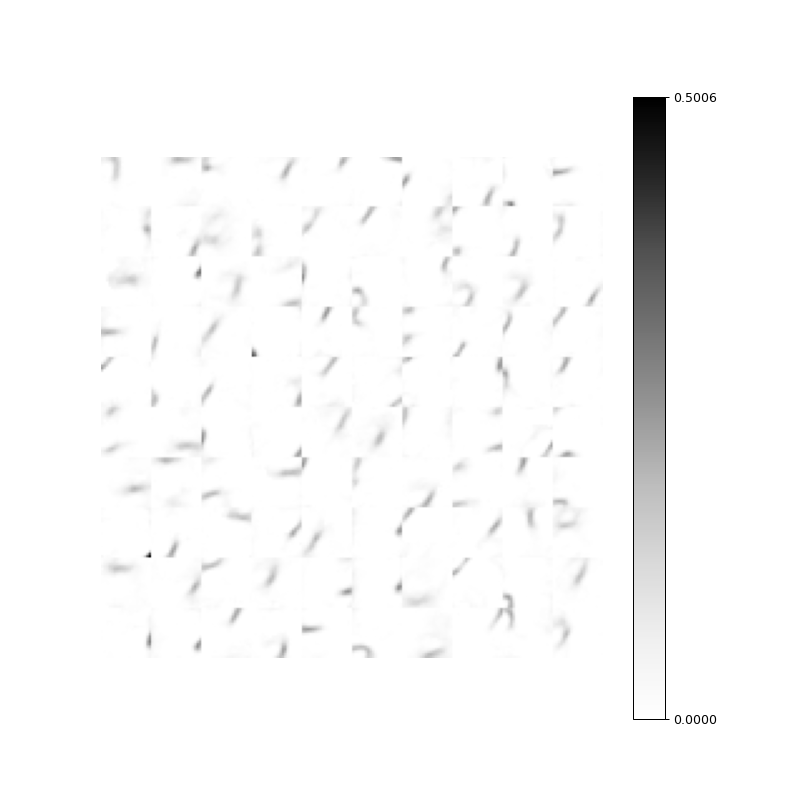

100%|█████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1661.96it/s]


In [19]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 3 # Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.01

# Lateral excitation
ex = 2

lat_ex_mask = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex_mask.append(curr_ex.reshape(-1))

# lex -> lateral excitation
lex_mask = np.array(lat_ex_mask)
np.fill_diagonal(lex_mask, 0)

lex = np.random.uniform(0, 1, (N, N)) * lex_mask

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        
        p1 = w_v / np.sum(w, axis=1).reshape(-1, 1)
        p2 = w_v + (lex @ p1)
        
        winners = np.argsort(p2, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p2
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        l_r = lex.T @ o
        mlr = np.maximum(l_r, prec)
        elr = o - l_r
        
        lex += lex * o * (elr / mlr).T * xi
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


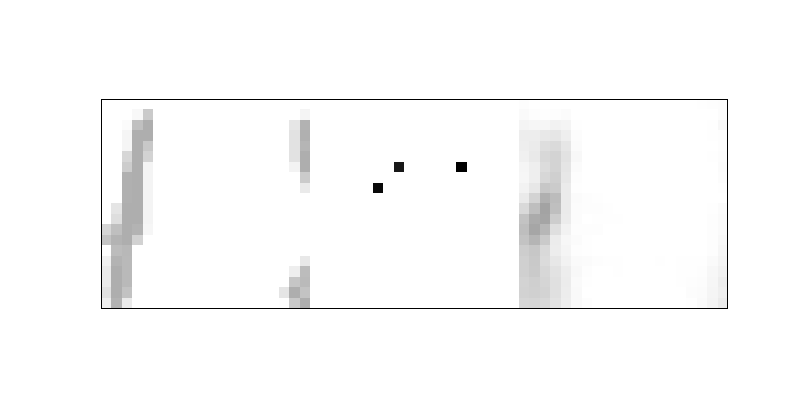

100%|█████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1003.26it/s]


In [33]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    w_v = w @ v

    p1 = w_v / np.sum(w, axis=1).reshape(-1, 1)
    p2 = w_v + (lex @ p1)

    winners = np.argsort(p2, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p2
    r = w.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
#     mini_tap[:, 20:40] = o.reshape(20, 20)
    mini_tap[5:15, 25:35] = o.reshape(10, 10)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Shoot dang!  That's at least somewhat promising.  So basically, I'm doing reconstructions again! I'm trying to reconstruct each neuron from its lateral connections.  The only problem is that I don't think I'm giving the network enough lateral connections.  

Well, whatever.  I'm going to try this architecture with 400 neurons, see how that goes.

<IPython.core.display.Javascript object>


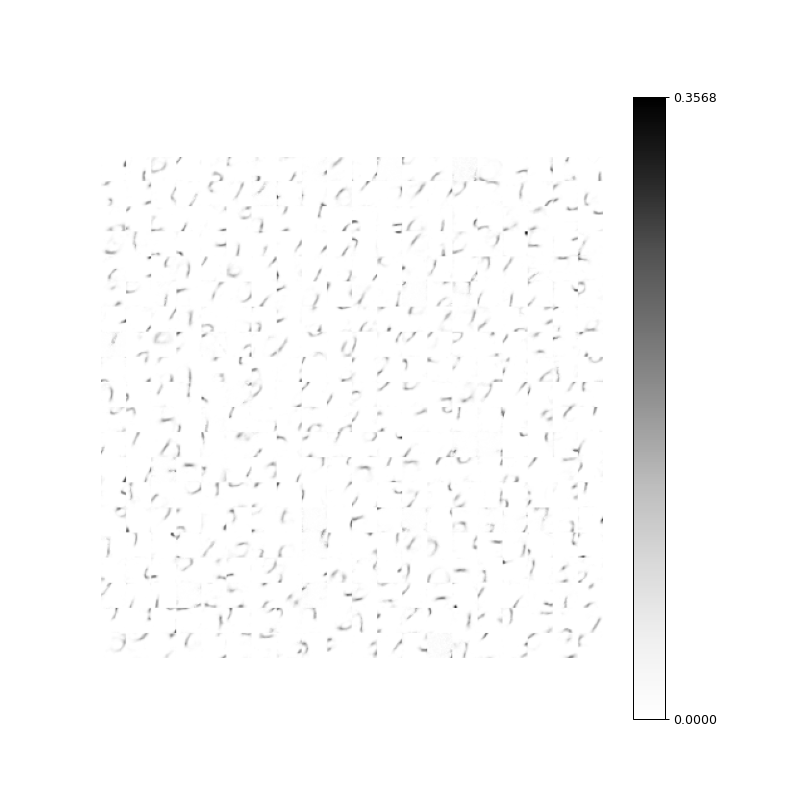

100%|████████████████████████████████████████████████████████████| 2500/2500 [00:13<00:00, 190.34it/s]


In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 2_500

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 5 # Number of winners

# Feedforward
w = np.random.uniform(0, 1, (N, m_len))
xi = 0.01

# Lateral excitation
ex = 2

lat_ex_mask = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex_mask.append(curr_ex.reshape(-1))

# lex -> lateral excitation
lex_mask = np.array(lat_ex_mask)
np.fill_diagonal(lex_mask, 0)

lex = np.random.uniform(0, 1, (N, N)) * lex_mask

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        
        p1 = w_v / np.sum(w, axis=1).reshape(-1, 1)
        p2 = w_v + (lex @ p1)
        
        winners = np.argsort(p2, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p2
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        l_r = lex.T @ o
        mlr = np.maximum(l_r, prec)
        elr = o - l_r
        
        lex += lex * o * (elr / mlr).T * xi
        
        if i % 1000 == 0:
            w = np.maximum(0, w)
            lex = np.maximum(0, lex)
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


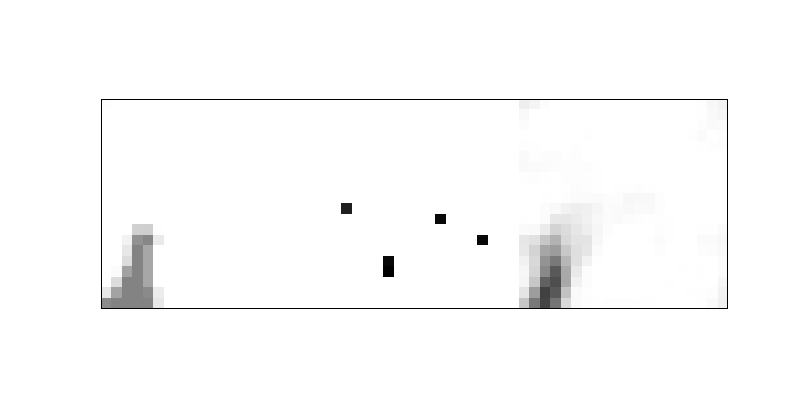

100%|██████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 774.67it/s]


In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    w_v = w @ v

    p1 = w_v / np.sum(w, axis=1).reshape(-1, 1)
    p2 = w_v + (lex @ p1)

    winners = np.argsort(p2, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p2
    r = w.T @ o
    
    
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = o.reshape(20, 20)
#     mini_tap[5:15, 25:35] = o.reshape(10, 10)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Hmm, there isn't a semblance of localization.  But is that a bad thing though?  I'm not sure.  The reconstruction is pretty ok.

I'm going to try it with 10 winners, and see what happens.  But first, let's look at some of the lateral connections.

<IPython.core.display.Javascript object>


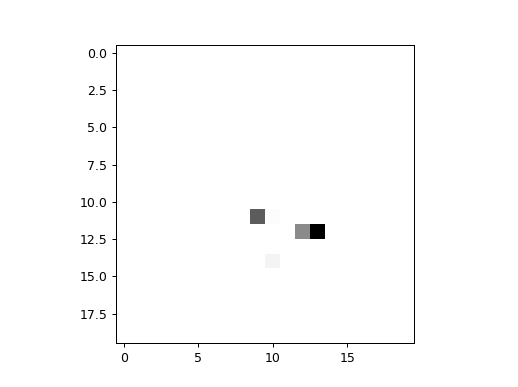

0.12366376941234024


In [13]:
plt.figure()
plt.imshow(lex[251].reshape(20, 20), cmap="Greys")
print(np.max(lex[251]))

In [14]:
print(np.max(w[251]))

0.1940247019558967


Interesting.  It almost looks like the lateral synapses are being treated the same way as the feed-forward synapses.  That's absolutely fascinating.

I'm going to make a fancy plot showing which lateral neurons are most correlated to a given neuron.

<IPython.core.display.Javascript object>


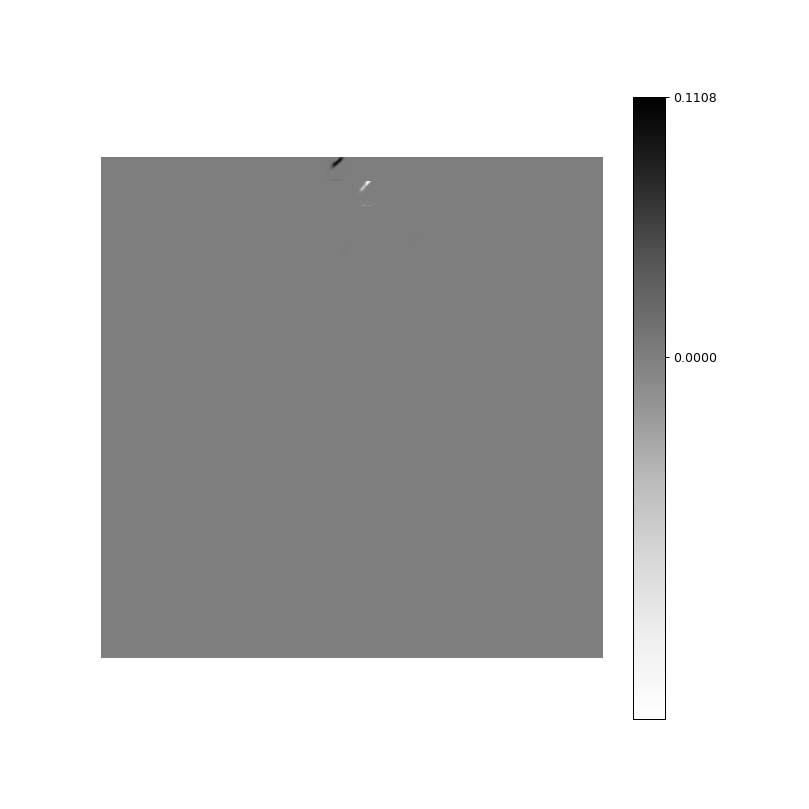

In [22]:
fig = plt.figure(figsize=(10, 10))


n_i = 30

nf = lex[n_i].reshape(-1, 1)
nf[n_i] = -max(nf)

draw_weights(w * nf, Kx, Ky, sl, fig)

Play around with that if you'd like.  

Before I do 10 winners, I'm going to try using the full swath for lateral excitation.  Let's see how that does.

<IPython.core.display.Javascript object>


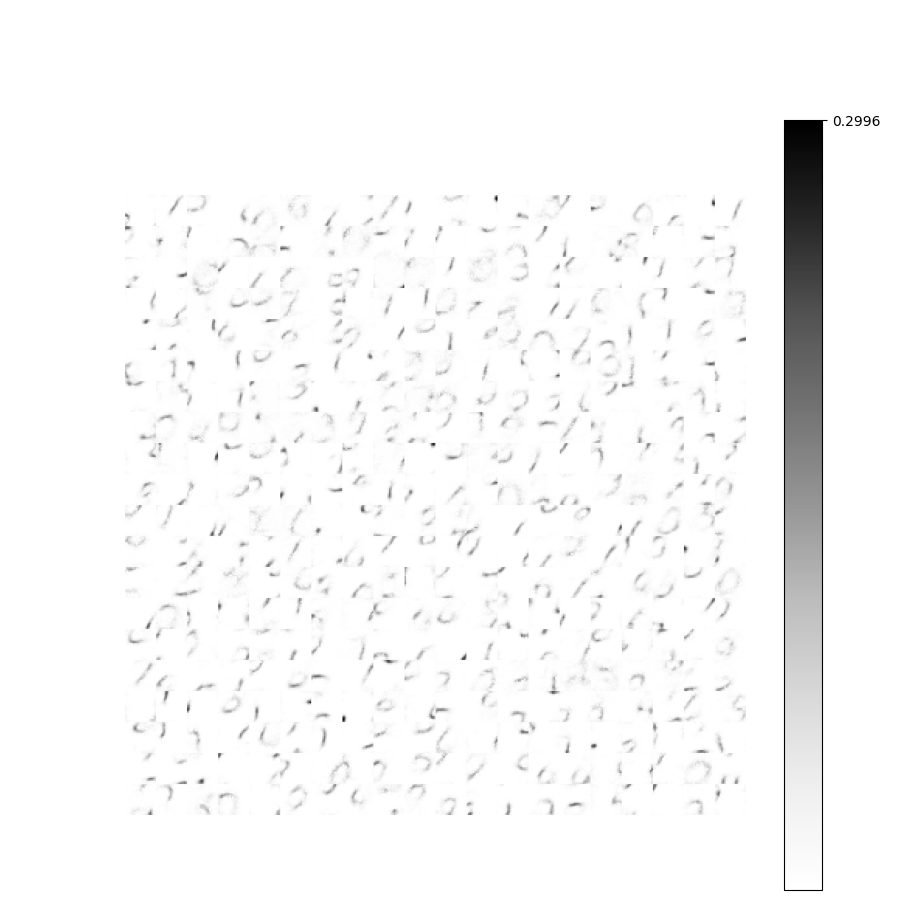

 15%|█████████▏                                                   | 377/2500 [00:02<00:11, 184.80it/s]


KeyboardInterrupt: 

In [37]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 2_500

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

max_syn = 0.5

prec = 1e-10

n_w = 5 # Number of winners

# Feedforward
w = np.random.uniform(0, max_syn, (N, m_len))
xi = 0.01

# Lateral excitation
ex = 2

# lat_ex_mask = []

# for y in range(Ky):
#     for x in range(Kx):
#         curr_ex = np.zeros((Ky, Kx))
#         curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
#         lat_ex_mask.append(curr_ex.reshape(-1))

# # lex -> lateral excitation
# lex_mask = np.array(lat_ex_mask)
# np.fill_diagonal(lex_mask, 0)

lex = np.random.uniform(0, max_syn, (N, N)) #* lex_mask
np.fill_diagonal(lex, 0)

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        
        p1 = w_v / np.sum(w, axis=1).reshape(-1, 1)
        p2 = w_v + (lex @ p1)
        
        winners = np.argsort(p2, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p2
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        l_r = lex.T @ o
        mlr = np.maximum(l_r, prec)
        elr = o - l_r
        
        lex += lex * o * (elr / mlr).T * xi
        
        if i % 100 == 0:
            w = np.clip(w, 0, max_syn)
            lex = np.clip(lex, 0, max_syn)
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


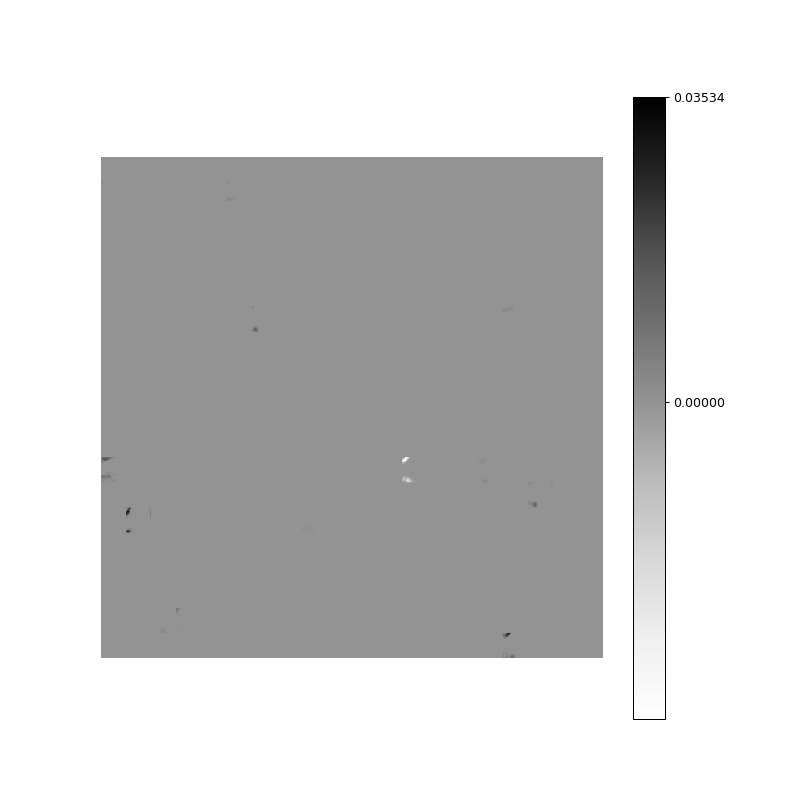

0.1992149583744644


In [42]:
fig = plt.figure(figsize=(10, 10))


n_i = 252

nf = lex[n_i].reshape(-1, 1)
nf[n_i] = -max(nf)

print(np.max(lex[n_i]))

draw_weights(w * nf, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


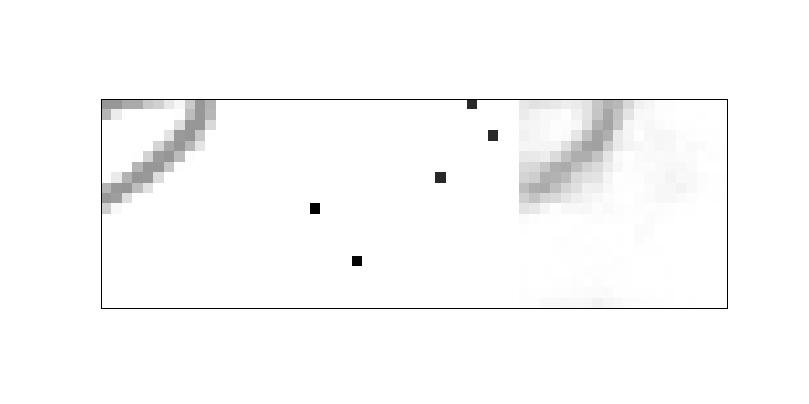

100%|██████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 850.69it/s]


In [43]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    w_v = w @ v

    p1 = w_v / np.sum(w, axis=1).reshape(-1, 1)
    p2 = w_v + (lex @ p1)

    winners = np.argsort(p2, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p2
    r = w.T @ o
    
    
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = o.reshape(20, 20)
#     mini_tap[5:15, 25:35] = o.reshape(10, 10)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok!  I think this is good!  Obviously the sparse layer isn't really localized, but I think there should hopefully be some level of lateral connection forming amongst the neurons.  

If I haven't said it already, the lateral connections are super great because the invariant layer won't exactly be able to properly reconstruct given no inputs, because it's a many-to-one connection.  Therefore, I need some way to capture the sparse layer's structure so the layer can orient itself into persistent patterns only given the invariant signal.  

It actually might be a good idea to have sparse neurons intermixed with invariant neurons.  Eh, maybe not.  Their main point should be to isolate structure, and if I can do that with lateral excitation, that's easier and requires less hardware.  

So dope!  I think stuff is good in the hood!  

That being said, I think there might be better ways for promoting lateral topology.

I'm going to try something real quick.

Actually, I'm not.  The thing I was going to try is quite difficult, and I'm not sure if there's a good way to do it.  Basically, I was going use constant lateral synapses, but adjust them so the reconstruction is as good as possible.  Basically, enforce some level of topology.  Guess not.  

Ok, I'm going to do 8 winners, and then wrap this bad boi up.

<IPython.core.display.Javascript object>


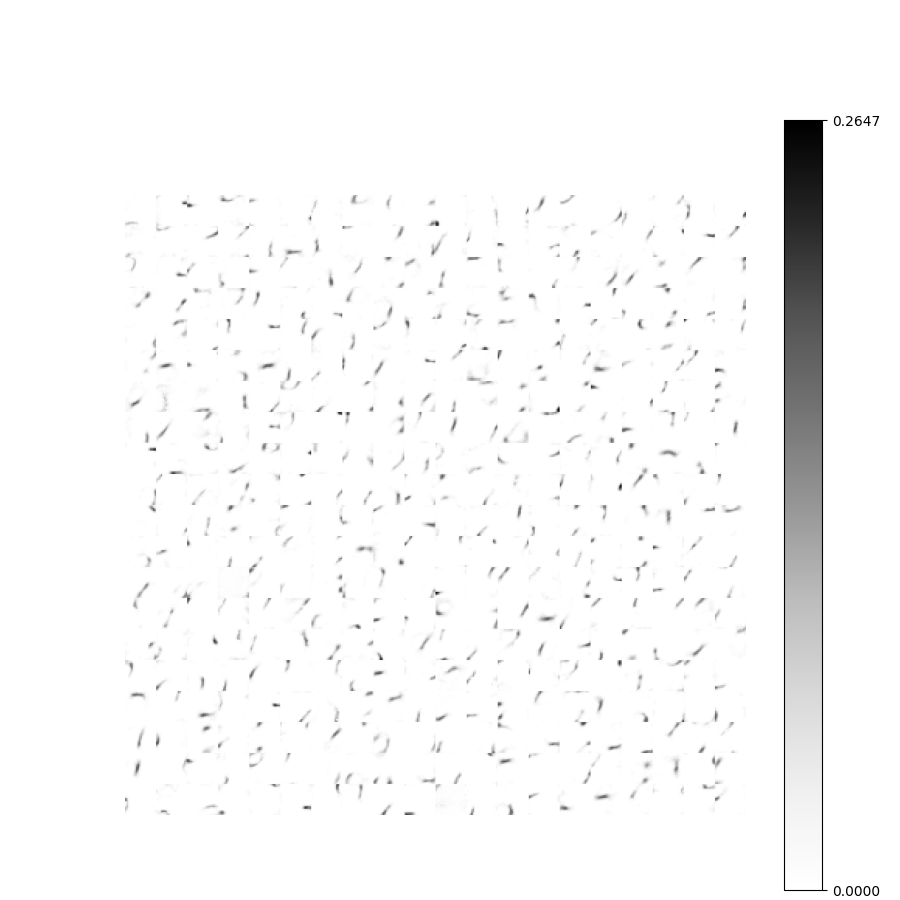

 19%|███████████▍                                                 | 468/2500 [00:02<00:11, 181.27it/s]


KeyboardInterrupt: 

In [44]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 2_500

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

max_syn = 0.5

prec = 1e-10

n_w = 8 # Number of winners

# Feedforward
w = np.random.uniform(0, max_syn, (N, m_len))
xi = 0.01

# Lateral excitation
ex = 2

# lat_ex_mask = []

# for y in range(Ky):
#     for x in range(Kx):
#         curr_ex = np.zeros((Ky, Kx))
#         curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
#         lat_ex_mask.append(curr_ex.reshape(-1))

# # lex -> lateral excitation
# lex_mask = np.array(lat_ex_mask)
# np.fill_diagonal(lex_mask, 0)

lex = np.random.uniform(0, max_syn, (N, N)) #* lex_mask
np.fill_diagonal(lex, 0)

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        
        p1 = w_v / np.sum(w, axis=1).reshape(-1, 1)
        p2 = w_v + (lex @ p1)
        
        winners = np.argsort(p2, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * p2
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        l_r = lex.T @ o
        mlr = np.maximum(l_r, prec)
        elr = o - l_r
        
        lex += lex * o * (elr / mlr).T * xi
        
        if i % 100 == 0:
            w = np.clip(w, 0, max_syn)
            lex = np.clip(lex, 0, max_syn)
        
    draw_weights(w, Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


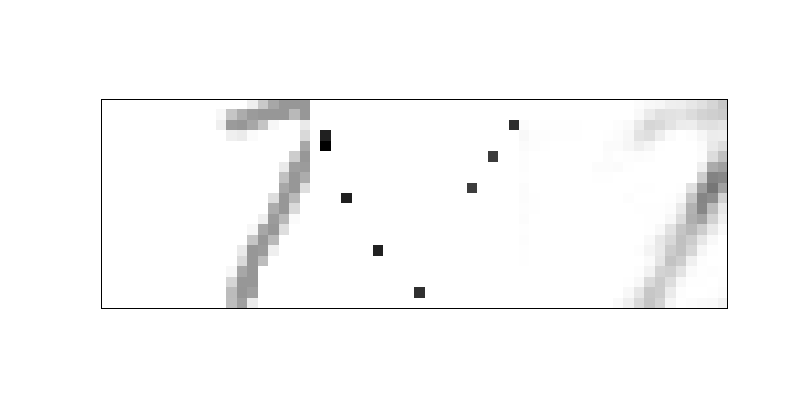

100%|██████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 884.44it/s]


In [45]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    w_v = w @ v

    p1 = w_v / np.sum(w, axis=1).reshape(-1, 1)
    p2 = w_v + (lex @ p1)

    winners = np.argsort(p2, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p2
    r = w.T @ o
    
    
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = o.reshape(20, 20)
#     mini_tap[5:15, 25:35] = o.reshape(10, 10)
    mini_tap[:, 40:60] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Pretty good.  Actually, you know what?  I'm going to do constant topological connections again, but this time, I'm going to make it so that lateral connections guaranteed to be as important as feed-forward synapses.

<IPython.core.display.Javascript object>


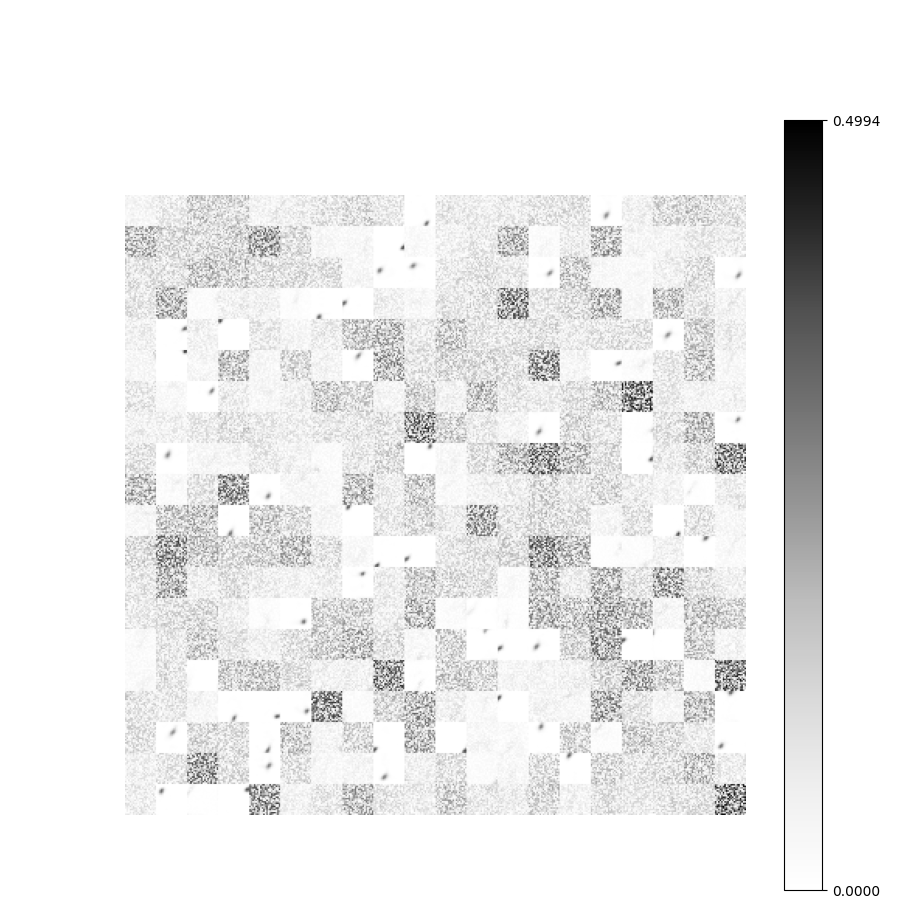

 27%|████████████████▋                                            | 685/2500 [00:02<00:05, 338.13it/s]


KeyboardInterrupt: 

In [58]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 2_500

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

max_syn = 0.5

prec = 1e-10

n_w = 8 # Number of winners

# Feedforward
w = np.random.uniform(0, max_syn, (N, m_len))
xi = 0.005

# Lateral excitation
ex = 1

lat_ex_mask = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex_mask.append(curr_ex.reshape(-1))

# lex -> lateral excitation
lex = np.array(lat_ex_mask)
np.fill_diagonal(lex, 0)
lex = lex / np.sum(lex, axis=1).reshape(-1, 1)

# lex = np.random.uniform(0, max_syn, (N, N)) #* lex_mask
# np.fill_diagonal(lex, 0)

for ep in range(Nep):
    inputs = ts_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        
        p1 = w_v / np.sum(w, axis=1).reshape(-1, 1)
        p2 = (3 * p1 + (lex @ p1)) / 4
        
        winners = np.argsort(p2, axis=0)[-n_w:]
        mask = np.zeros((N, 1))
        mask[winners] = 1
        o = mask * w_v
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 100 == 0:
            w = np.clip(w, 0, max_syn)
            lex = np.clip(lex, 0, max_syn)
        
    draw_weights(w, Kx, Ky, sl, fig)

Well, that was totally wild and unexpected.  Why the heck did that happen?  

I guess it's something with domination again.

Well, whatever.  I'll cross this bridge when I get to it.

## Conclusions

Doing lateral reconstructions seems to be a reasonable way to do lateral excitation and topological formation without anything going haywire.  That's pretty dope.

Oh yeah, also weighted averages are the literal worst, now and forever more.  

Basically, the main thing to do now is to get going with the invariant layer.  

## Next steps

I investigated the normalization problem, now it's time for the invariant layer.  

...that's what's next, bois.